# Analysis of output files
## Prepare environment, functions etc.

In [1]:
import os
import sys
import pandas
import matplotlib
import numpy
from algorithm_tester.helpers import FilePair

# Zapnout zobrazování grafů (procento uvozuje „magickou” zkratku IPythonu):
%matplotlib inline

path = 'tester_results'
solutions = '../data'

In [2]:
#pandas.set_option('display.max_rows', None)
#pandas.read_csv?

## Important functions

In [3]:
def get_file_paths_from_dir(path: str, include_sol: bool = False, include_instance: bool = True) -> (str, str):
    dataset_prefix: str = path.split("/")[-1]
    for root, _, files in os.walk(path):
        dataset: str = dataset_prefix + "_" + "_".join(root.replace(path, "")[1:].split('/'))
        for file in files:
            if "column" not in file:
                if ("_sol" in file and include_sol) or ("_inst" in file and include_instance):
                    yield (dataset, f'{root}/{file}')

def get_cols_list(path: str):
    cols = pandas.read_csv(path, index_col=None, delimiter=" ", header=None)
    return list(cols.iloc[0])

def load_sol_from_dir(folder_path: str, column_list):
    """ Load solutions from directory files into table. """
    it = get_file_paths_from_dir(folder_path, include_sol=True, include_instance=False)
    output_table = None
        
    for (dataset, filepath) in it:
        curr_table = pandas.read_csv(filepath, index_col=None, delimiter=" ", header=None).iloc[:,0:3]
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    return output_table

def load_data_from_dir(folder_path: str, column_list):
    """ Load data from directory files into table. """
    it = get_file_paths_from_dir(folder_path)
    output_table = None
    
    for (dataset, filepath) in it:
        curr_table = pandas.read_csv(filepath, index_col=None, delimiter=" ", header=None)
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    #output_table = output_table.set_index(['algorithm', 'dataset', 'id', "item_count"])
    #output_table.sort_values(by=["algorithm", "dataset", "item_count", "id"], inplace=True)
    return output_table

def construct_table_from(filePair: FilePair):
    solution_table = pandas.read_csv(filePair.solutionFile, header=None, index_col=None, delimiter=" ")
    data_table = pandas.read_csv(filePair.dataFile, header=None, index_col=None, delimiter=" ")
    
    item_count = data_table.iloc[0, 1]
    
    solution_table = solution_table.drop_duplicates(subset=[0], keep='first').reset_index()

    data_table = data_table.iloc[:, 4:]
    data_table = data_table[data_table.columns[::2]]

    info_table = pandas.concat([solution_table.iloc[:, 1], solution_table.iloc[:, 3], data_table.max(axis=1)], axis=1)
    info_table.columns = ["id", "best_value", "max_cost"]
    info_table["item_count"] = item_count
    return info_table

def create_avg_time(table, name: str, column: str = "item_count"):
    # Create a table of average times according to algorithm and item_count columns
    avg_times = table.groupby(["algorithm", column])['time[#configs]'] \
        .mean().reset_index().set_index(["algorithm", column])
    avg_times = avg_times.round(2)

    # Move all values of algorithm column into separate columns
    avg_times = avg_times.unstack("algorithm")
    avg_times.columns = avg_times.columns.droplevel()
    avg_times.name = f"Avg #configs per {column}"
    #avg_times.fillna("-", inplace=True)

    # Save the dataframe to csv
    avg_times.to_excel(f'excel/{name}_avg_times.xlsx', sheet_name=name)
    
    return avg_times

def create_avg_error(table, name: str, column: str, exact_strategy_name: str = "DP"):
    greedy_table = table.iloc[table.index.get_level_values('algorithm') == "Greedy"] \
        .rename(columns={'maximum_sum':'found_sum'})
    exact_table = table.iloc[table.index.get_level_values('algorithm') == exact_strategy_name] \
        .drop(columns="time[#configs]")
    
    if column not in greedy_table.index.names:
        greedy_table = greedy_table.loc[:, ["found_sum", column]]
        greedy_table = pandas.merge(greedy_table, exact_table, how="left", on=['id', 'item_count', column])
    else:
        greedy_table = greedy_table.loc[:, ["found_sum"]]
        greedy_table = pandas.merge(greedy_table, exact_table, how="left", on=['id', 'item_count'])
        
    greedy_table["relative_error"] = numpy.abs(greedy_table["maximum_sum"] - greedy_table["found_sum"])/greedy_table["maximum_sum"]
        
    # Create a table with max and average relative_error.
    error_group = greedy_table.groupby([column])["relative_error"]

    error_max = error_group.max().reset_index().set_index([column]) \
        .rename(columns={'relative_error':'max_relative_error'})
    error_avg = error_group.mean().reset_index().set_index([column]) \
        .rename(columns={'relative_error':'avg_relative_error'})

    # Construct, unstack
    avg_error = error_max.join(error_avg).round(6)
    avg_error.columns = ["max_relative_error", "avg_relative_error"]
    avg_error.name = f"Avg & max relative error per {column}"

    avg_error.to_excel(f"excel/{name}_avg_error.xlsx", sheet_name=name)

    return avg_error

In [4]:
# Create column lists

sol_cols = ["id", "item_count", "best_value"]
cols = get_cols_list(f'{path}/column_description.dat')

## Put data from all analysis files into tables

In [5]:
# Load tables of all strategies
#balance_table = load_data_from_dir(f'{path}/Balance', cols) \
#    .rename(columns={'instance_info':'balance'})
#robust_table = load_data_from_dir(f'{path}/Robust', cols) \
#    .drop(columns="instance_info")

nk_table = load_data_from_dir(f'{path}/NK', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/NK', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkc_table = load_data_from_dir(f'{path}/ZKC', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKC', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkw_table = load_data_from_dir(f'{path}/ZKW', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKW', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
nk_table

,id,item_count,algorithm_name,init_temperature,cooling,min_temperature,cycles,found_value,elapsed_configs,elapsed_time,dataset,best_value
0,1,40,SA,1000.0,0.995,1.0,50,36583,68950,354.030617,NK_,38667
1,1,40,SAPenalty,1000.0,0.995,1.0,50,22817,68950,400.976691,NK_,38667
2,2,40,SA,1000.0,0.995,1.0,50,28611,68950,584.387324,NK_,28802
3,2,40,SAPenalty,1000.0,0.995,1.0,50,17713,68950,392.843786,NK_,28802
4,3,40,SA,1000.0,0.995,1.0,50,41155,68950,393.383550,NK_,43501
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,498,30,SA,1000.0,0.995,1.0,50,38957,68950,341.111273,NK_,39283
4996,499,30,SAPenalty,1000.0,0.995,1.0,50,9183,68950,390.139960,NK_,14416
4997,499,30,SA,1000.0,0.995,1.0,50,14416,68950,647.209041,NK_,14416
4998,500,30,SAPenalty,1000.0,0.995,1.0,50,7142,68950,393.274741,NK_,14262


In [6]:
table = zkw_table
table["relative_error"] = numpy.abs(table["best_value"] - table["found_value"])/table["best_value"]
table.query("relative_error > 1")

,id,item_count,algorithm_name,init_temperature,cooling,min_temperature,cycles,found_value,elapsed_configs,elapsed_time,dataset,best_value,relative_error


# Parameter analysis

In [7]:
param_sols = load_sol_from_dir(f'{solutions}/ParamAnalysis', sol_cols) \
    .drop(columns="dataset")

init_temperature_table = load_data_from_dir(f'{path}/ParamAnalysis/InitTemperature', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])

cooling_table = load_data_from_dir(f'{path}/ParamAnalysis/Cooling', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "init_temperature"]) \
    .merge(param_sols, on=["id", "item_count"])

cycles_table = load_data_from_dir(f'{path}/ParamAnalysis/Cycles', cols) \
    .drop(columns=["things", "init_temperature", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])

init_temperature_table["dataset"] = init_temperature_table["dataset"].str.split("_", n = 1, expand = True)[1]
cooling_table["dataset"] = cooling_table["dataset"].str.split("_", n = 1, expand = True)[1]
cycles_table["dataset"] = cycles_table["dataset"].str.split("_", n = 1, expand = True)[1]

cycles_table


,id,item_count,algorithm_name,cycles,found_value,elapsed_configs,elapsed_time,dataset,best_value
0,1,32,SA,50,32944,62000,36.656311,50,32944
1,1,32,SAPenalty,50,19511,62000,362.063035,50,32944
2,1,32,SA,150,32944,186000,100.629124,150,32944
3,1,32,SAPenalty,150,19511,186000,1080.871931,150,32944
4,1,32,SA,250,32944,310000,171.289442,250,32944
...,...,...,...,...,...,...,...,...,...
12085,500,35,SA,250,29457,310000,181.194610,250,29684
12086,500,35,SAPenalty,100,14421,124000,720.743173,100,29684
12087,500,35,SA,100,29457,124000,62.487500,100,29684
12088,500,35,SAPenalty,200,14421,248000,1429.187039,200,29684


In [8]:


def f(table):
    table["relative_error"] = numpy.abs(table["best_value"] - table["found_value"])/table["best_value"]
    table = table.fillna(0) \
        .replace([numpy.inf, -numpy.inf], numpy.nan).dropna()
    
    error_group = table.groupby(["dataset", "algorithm_name"])["relative_error"]

    error_max = error_group.max().reset_index() \
        .rename(columns={'relative_error':'max_relative_error'})
    error_avg = error_group.mean().reset_index() \
        .rename(columns={'relative_error':'avg_relative_error'})
    
    # Construct, unstack
    avg_error = pandas.merge(error_max, error_avg, on=["dataset", "algorithm_name"])
    #avg_error = error_max.join(error_avg).round(6)
    #avg_error.columns = ["max_relative_error", "avg_relative_error"]
    avg_error.name = f"Avg & max relative error per "

    #avg_error.to_excel(f"excel/{name}_avg_error.xlsx", sheet_name=name)
    
    return avg_error

error_init_temperature = f(init_temperature_table).astype({'dataset': 'int'}).sort_values(by="dataset")
error_cooling = f(cooling_table).astype({'dataset': 'float'}).sort_values(by="dataset")
error_cycles = f(cycles_table).astype({'dataset': 'int'}).sort_values(by="dataset")

In [24]:
error_cycles

,dataset,algorithm_name,max_relative_error,avg_relative_error
8,50,SA,0.598615,0.023078
9,50,SAPenalty,0.767103,0.429593
0,100,SA,0.598615,0.023078
1,100,SAPenalty,0.767103,0.429880
2,150,SA,0.598615,0.023078
3,150,SAPenalty,0.835176,0.430669
4,200,SA,0.598615,0.023078
5,200,SAPenalty,0.835176,0.430667
6,250,SA,0.598615,0.023078
7,250,SAPenalty,0.767103,0.430377


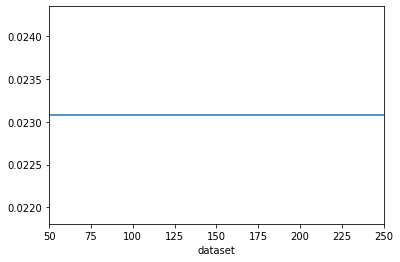

In [23]:
error_cycles.query('algorithm_name == "SA"').set_index("dataset").loc[:, "avg_relative_error"].plot()

## DataAnalysis

In [18]:
dpath = f'{path}/DataAnalysis'

balance_table = load_data_from_dir(f'{dpath}/Balance', cols) \
    .rename(columns={'instance_info':'balance'})
correlation_table = load_data_from_dir(f'{dpath}/Correlation', cols) \
    .rename(columns={'instance_info':'correlation'})
granularity_heavy_table = load_data_from_dir(f'{dpath}/GranularityHeavy', cols) \
    .rename(columns={'instance_info':'constant'})
granularity_light_table = load_data_from_dir(f'{dpath}/GranularityLight', cols) \
    .rename(columns={'instance_info':'constant'})
maxcost_table = load_data_from_dir(f'{dpath}/MaxCost', cols) \
    .rename(columns={'instance_info':'maxcost'})
maxweight_table = load_data_from_dir(f'{dpath}/MaxWeight', cols) \
    .rename(columns={'instance_info':'maxweight'})
things_table = load_data_from_dir(f'{dpath}/Things', cols)
weight_cap_ratio_table = load_data_from_dir(f'{dpath}/WeightCapRation', cols) \
    .rename(columns={'instance_info':'ratio'})

In [ ]:
balance_table

In [14]:
init_temperature_table.query("algorithm_name == 'SA'")

,id,item_count,algorithm_name,init_temperature,found_value,elapsed_configs,elapsed_time,dataset,best_value,relative_error
0,1,32,SA,300.0,32944,56900,30.428554,300,32944,0.000000
2,1,32,SA,900.0,32944,67900,35.284840,900,32944,0.000000
4,1,32,SA,700.0,32944,65350,41.178749,700,32944,0.000000
6,1,32,SA,100.0,32944,45950,26.917117,100,32944,0.000000
8,1,32,SA,500.0,32944,62000,35.491148,500,32944,0.000000
...,...,...,...,...,...,...,...,...,...,...
16917,500,35,SA,700.0,29457,65350,34.942256,700,29684,0.007647
16919,500,35,SA,100.0,29457,45950,23.897490,100,29684,0.007647
16921,500,35,SA,500.0,29457,62000,34.223114,500,29684,0.007647
16923,500,35,SA,1000.0,29457,68950,35.725114,1000,29684,0.007647
